In [1]:
__nbid__ = '0056'
__author__ = 'Robert Dzudzar <robertdzudzar@gmail.com>; <rdzudzar@swin.edu.au>, Robert Nikutta <robert.nikutta@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20250918' # yyyymmdd
__keywords__ = ['extragalactic', 'interactive plot', 'spectra', 'galaxies', 'image cutout', 'sia']

# Interactively examining the HI Parkes All Sky Survey (HIPASS)
*Robert Dzudzar, Robert Nikutta, Alice Jacques*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Import HIPASS data](#chapter1)
* [Plot the Sky coverage of the HIPASS survey](#chapter1.1)
* [Choose dataset to visualize](#chapter1.2)
* [Scraping URLs where the data of the HIPASS spectra is stored](#chapter1.3)
* [Creating list of HIPASS sources](#chapter1.4)
* [Extracting spectral information from HIPASS database](#chapter1.5)
* [Search for the HIPASS objects in the Astro Data Archive SIA service](#chapter2.1)
* [Interactive visualization with Bokeh](#chapter4)  
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is for interactive exploration of the multiwavelength data, in particular: a combination of the radio data (measured properties and HI emission line spectra) from the HI Parks All Sky Survey and the optical data. 

# Summary
We utilize data from the HI Parks All Sky Survey (HIPASS) presented in https://ui.adsabs.harvard.edu/?#abs/2004MNRAS.350.1195M and publicly available at https://www.parkes.atnf.csiro.au/research/multibeam/release/. The HIPASS data are presented in the form of numerical properties of the sources (galaxies) and their HI emission line spectra. We obtain the HI spectra from the HIPASS database and query their optical images from the Astro Data Archive SIA service. Both datasets are then combined in an interactive environment, which enables numerical and visual examination of the data.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
import requests
from io import StringIO

# 3rd party
import numpy as np
import matplotlib
import pylab as plt
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm #progress bar
from urllib.parse import urlencode

# astropy
from astropy.table import Table

# bokeh
from bokeh.io import output_notebook
from bokeh.palettes import viridis
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource, ColorBar, HoverTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource, save
output_notebook()

# Data Lab
from pyvo.dal import sia

Loading BokehJS ...

<a class="anchor" id="chapter1"></a>
# Import HIPASS data

In [3]:
# Load galaxy properties from HIPASS data (https://ui.adsabs.harvard.edu/abs/2004MNRAS.350.1195M/abstract)
HIPASS_data = Table.read('HIPASS_catalog.fit')

# Store HIPASS.fit table into Pandas dataframe
df_hipass = HIPASS_data.to_pandas()

# Display the dataframe head to see partial content
df_hipass.head()

,_RAJ2000,_DEJ2000,HIPASS,RAJ2000,DEJ2000,RV50max,RV50min,RV20max,RV20min,RVmom,...,RMScube,cube,Sigma,Boxsize,Qual,nb,cf,ext,Spectrum,SimbadName
0,0.107500,-7.832222,b'J0000-07 ',b'00 00 25.8',b'-07 49 56',3747.8,3747.8,3721.8,3721.8,3728.2,...,0.0115,336,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0000-07 \r'
1,0.134583,-40.498333,b'J0000-40 ',b'00 00 32.3',b'-40 29 54',3170.8,3170.8,3169.6,3169.6,3167.9,...,0.0115,146,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0000-40 \r'
2,0.502083,-3.283611,b'J0002-03 ',b'00 02 00.5',b'-03 17 01',6001.8,6001.8,6005.3,6005.3,6002.0,...,0.0115,337,158,28,1,0,0,0,b'Spectrum',b'HIPASSJ0002-03 \r'
3,0.515417,-7.632222,b'J0002-07 ',b'00 02 03.7',b'-07 37 56',3764.8,3764.8,3764.0,3764.0,3765.2,...,0.0122,286,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0002-07 \r'
4,0.622917,-15.973611,b'J0002-15 ',b'00 02 29.5',b'-15 58 25',3416.2,3416.2,3420.8,3420.8,3422.6,...,0.0115,237,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0002-15 \r'


<a class="anchor" id="chapter1.1"></a>
# Plot the Sky coverage of the HIPASS survey

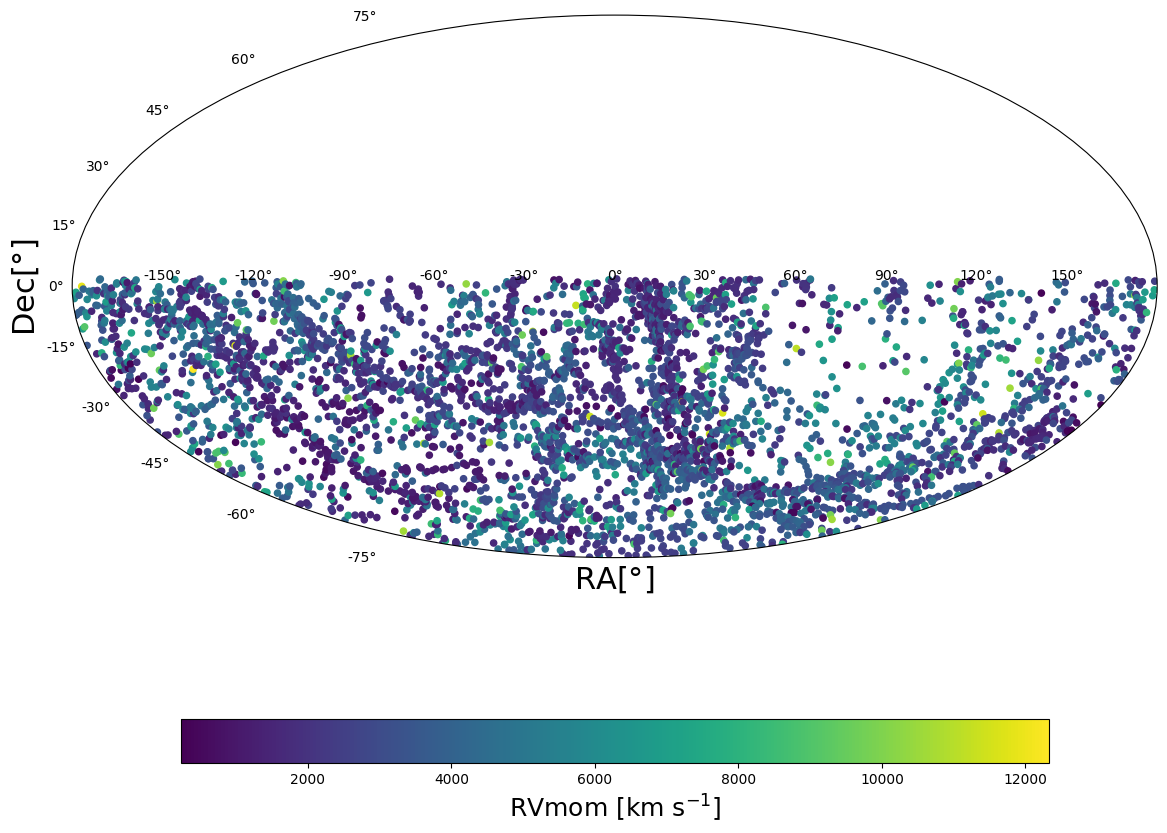

In [4]:
# Plot HIPASS survey

fig = plt.figure(figsize=(14,14))
# Using mollweide projection
ax = fig.add_subplot(111, projection="mollweide") 
# Converting RA and DEC from deg to radians
im = ax.scatter(np.radians(df_hipass['_RAJ2000']-180), np.radians(df_hipass['_DEJ2000']), c=df_hipass['RVmom'], cmap='viridis', s=20)
# Adding colorbar for the sources, based on their Velocity
cb = plt.colorbar(im, orientation = 'horizontal', shrink = 0.8)
# RVmom ==> Flux-weighted mean velocity of profile clipped at RVlo and RVhi (explained in the online HIPASS table)
cb.set_label(r'RVmom [km s$^{-1}$]', size=18) 

# Add axis labels and label sizes
ax.set_xlabel(r'$\mathrm{RA[\degree]}$',fontsize=22)
ax.set_ylabel(r'$\mathrm{Dec[\degree]}$',fontsize=22)
plt.show()

<a class="anchor" id="chapter1.2"></a>
# Choose dataset to visualise
### The selected dataset is 'most_massive' and 'Number_of_sources = 10' which selects 10 galaxies
Default is selected = 'most_massive'. Please be aware that depending on the internet, you might need a long time to proccess the notebook with large number of galaxies.
max(Number_of_sources) for confused sources is 333; otherwise it is 4315

In [5]:
Number_of_sources = 10

# Assign only one of the following: 'most_massive', 'least_massive', 'confused'

selected = 'most_massive'

# For example, if selected = 'most_massive' it will compute sub-sample of the X most massive galaxies, where X
# is the Number_of sources; if you type selected = 'least_massive' it will do the same for the X least massive sources

In [6]:
# Create a dictionary with possible selections 
select_dict = {
  'most_massive' : (False, 'logHI_mass_approx'),
  'least_massive' : (True, 'logHI_mass_approx'),
  'confused' : (False, 'cf')
}

# Create the dataframe based on the selected conditions

In [7]:
H0 = 70 # Hubble constant
# Add distance HI mass to the table
# These are created by adopting RVmom as the recessional velocity for distance (RVmom * H0) and mass estimation! 
df_hipass['logHI_mass_approx'] = pd.Series(np.log10(2.365*10e5*((df_hipass['RVmom']/H0)**2)*df_hipass['Sint']), index=df_hipass.index)
df_hipass['Distance_approx'] = pd.Series( (df_hipass['RVmom']/H0), index=df_hipass.index)

# Check selected conditions and use parameters from the dictionary to sort/select correct sub-dataset
ascending_ = select_dict[selected][0]
by_ = select_dict[selected][1]

# Create sorted (based on the dataset selected above) pandas dataframe
df_selected = df_hipass.sort_values(by_, ascending = False).reset_index() # Creating selected dataset and sorting
df_selected = df_selected[0:Number_of_sources] # Getting the specific number of sources
df = df_selected # Save new dataframe

<a class="anchor" id="chapter1.3"></a>
# Scraping URLs where the data of the HIPASS spectra is stored

In [8]:
# Edit URL for each galaxy in HIPASS: for making URLs we need: RA, DEC, and a number of the cube from where data was extracted
# Needed data are provided in the HIPASS table: df['RAJ2000'], df['DEJ2000'] and df['cube']

# List of URLs
all_ascii = [] 
all_pngs = []
# Go through each galaxy from the dataframe
for galaxy in tqdm(range(len(df))):
    
    # Cube string can be example 9(99) from table, however, for URL request they need to be written as 009(099)
    # We check the cube number length and add 00(0) if needed.
    
    cube = "%03d" % df['cube'][galaxy]
    ra = df['RAJ2000'][galaxy].decode().replace(' ',':')
    dec = df['DEJ2000'][galaxy].decode().replace(' ',':')
    xmin = 2000
    xmax = 12000

    root = "https://www.parkes.atnf.csiro.au/cgi-bin/multi/release/download.cgi?"
    params = {"cubename": "/var/www/vhosts/www.parkes.atnf.csiro.au/htdocs/research/multibeam/release/MULTI_3_HIDE/PUBLIC/H%s_abcde_luther.FELO.imbin.vrd" % cube,
              "hann": 3,
              "coord": "%s,%s" % (ra,dec),
              "xrange": "%s,%s" % (xmin,xmax),
              "xaxis": "optical",
              "datasource": "hipass",
              "type": "ascii"}
    
    # Combine all acquired URL strings for each ASCII file and append it to `all_ascii`
    ascii1 = root + urlencode(params,safe='/')
    all_ascii.append(ascii1)

    # Combine all acquired URL strings for each PNG file and append it to `all_pngs`
    params["type"] = "png"
    png1 = root + urlencode(params,safe='/')
    all_pngs.append(png1)

100%|██████████| 10/10 [00:00<00:00, 11551.37it/s]


<a class="anchor" id="chapter1.4"></a>
# Creating list of HIPASS sources

In [9]:
# Extract the HIPASS source names from the table; String manipulation is needed to strip certain characters from name 
# Also, each source has string `HIPASS` in front of its table name, so we add that

HIPASS_sources = ['HIPASS'+df['HIPASS'][idx].decode().strip() for idx in range(len(df))]

<a class="anchor" id="chapter1.5"></a>
# Extracting spectral information from the HIPASS database

10it [00:11,  1.20s/it]


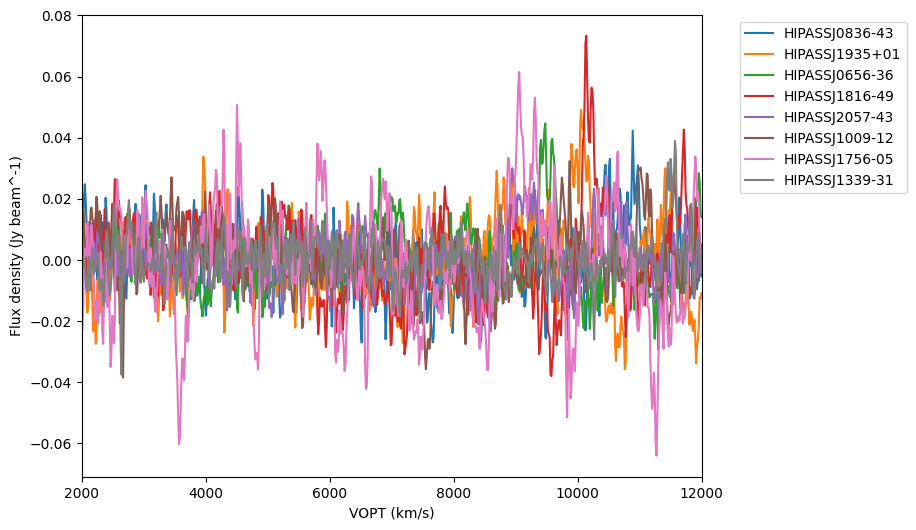

In [10]:
# We want to go to each URL and extract only the spectra data
# From each URL we need Channel, Velocity, and Intensity information
# Going through each URL, reading it with the BeautifulSoup and manipulating to get needed data
fig, ax = plt.subplots(figsize=(8,6))

for idx,galaxy in tqdm(enumerate(all_ascii)):
    res = requests.get(galaxy)

    # The CSIRO server unfortunately returns res.status_code = 200 (meaning 'OK') even when there was an error.
    # Instead, we will check whether a phrase about an error is return in res.text
    if res.status_code == 200 and 'following error has occured' not in res.text:
        soup = str(BeautifulSoup(res.text,'html.parser'))

        # The spectrum is returned an ASCII table, as part of the server response.
        # `find` gets the table from the response string, no matter where it starts.
        # `+3` gets rid of the leading comment char.
        # `replace` fixes the column name with whitespace
        datastr = soup[soup.find('#  Channel')+3:].replace('Spectral axis','Velocity')
        df_spec = pd.read_csv(StringIO(datastr),delim_whitespace=True)
   
        ax.plot(df_spec['Velocity'], df_spec['Intensity'], label=f'{HIPASS_sources[idx]}')

ax.set_xlim(2000,12000)
ax.set_xlabel('VOPT (km/s)')
ax.set_ylabel('Flux density (Jy beam^-1)')
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

<a class="anchor" id="chapter2.1"></a>
# Search for the HIPASS objects in the Astro Data Archive SIA service

In [11]:
# this URL tells the SIA service where to find images and image metadata
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

In [12]:
# Use the SIA service function to obtain image previews
def get_sia_preview(ra, dec, fov=0.09):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    sel = (imgTable['prodtype'] == 'image') & (imgTable['proctype'] == 'InstCal')
    Table = imgTable[sel]
    sia_preview = Table['preview'][0]
    return sia_preview

In [13]:
# Create a list of image previews to use in the Bokeh plot
try:
    list_images = [get_sia_preview(df['_RAJ2000'][i], df['_DEJ2000'][i]) for i in range(len(df['_RAJ2000']))]
except:
    pass

<a class="anchor" id="chapter4"></a>
# Interactive visualization with Bokeh

In [14]:
# Add bokeh features
# We are plotting x and y data
# As desc - description - we will have name of the object
# As spectra and imgs -- we will have spectrum image and optical image for each source as we hover above plotted points
# Depending on the speed of your internet, when first time hovering on points - wait a couple of seconds for images to appear

source = ColumnDataSource(
        data=dict(
            x = df['Distance_approx'], # x-axis on the plot
            y = df['logHI_mass_approx'], # y-axis on the plot
            z = df['W20max'], # colourbar on the plot
            desc = HIPASS_sources , # Source name in the hover
            confused = df['cf'], # Confused/Non-confused statement in the hover
            ra_obj = df['_RAJ2000'], # RA of the source in the hover
            dec_obj = df['_DEJ2000'], # DEC of the source in the hover
            spectra = all_pngs, # Spectrum image in the hover
            imgs = list_images,)) # Optical image in the hover

# Adding html code to say how the images, spectra and other information will be displayed when one hover on points
# Important things to notice here is connection to the source above. When you want to use specific item from the source, you 
# link it to the hover belov with: @item_name
# Other information is .html code to sort how the data will be displayed. 
# If bokeh hover tool is used without image display - .html code is not necessary.

hover = HoverTool(    tooltips="""
    <div>
        <div>
        
        </div>
            <span style="font-size: 17px; font-weight: bold; color: #c51b8a; ">@desc</span>
        </div>   
        
            <table>
            <tr>
            <td><img src="@imgs" width="200" alt="No image available" /></td>
            <td><img src="@spectra" width="200" alt="No spectra available" />                
            
            <center>
            </div>
                <span style="font-size: 12px; font-weight: bold;"> RA [deg] = @ra_obj</span>
                <br>
                <span style="font-size: 12px; font-weight: bold;"> DEC [deg] = @dec_obj</span>
            </div> 
            </center>
            </td>
            
            </tr> 
            </table>
            
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; font-weight: bold; color: #8856a7;">($x, $y )</span>

            <span style="font-size: 12px; font-weight: bold;">Confused source if=1: @confused</span>

    """
)
        
# Define figure size (width/height), assign tools (plot options, zoom, point selection, hover) and give name
p = figure(plot_width=700, plot_height=700, tools=[hover, "pan,wheel_zoom,box_zoom,reset"], 
           title="{0} galaxies from HIPASS".format(Number_of_sources), toolbar_location="above")

# Define axis labels and properties
p.xaxis.axis_label = 'Distance [Mpc]'
p.yaxis.axis_label = 'log HI Mass'
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"
p.title.text_font_size = '18pt'
p.xaxis.major_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"

# Use the field name of the column source. Here is specified what goes on the colour bar and which colour it is.
mapper = linear_cmap(field_name='z', palette=viridis(8) ,low=min(df['W20max']) ,high=max(df['W20max']))

# Plot x and y data. Link points to colourmap with mapper. Link hover to the source.
p.scatter('x', 'y', size=14,  line_color=mapper, color=mapper,  source=source, fill_alpha=0.7)

# Add colourbar to the plot.
color_bar = ColorBar(color_mapper=mapper['transform'], width=18,  location=(-2,-1), title='W20max')
p.add_layout(color_bar, 'right')

# Ticks sizes
p.axis.major_tick_out = 0
p.axis.major_tick_in = 12
p.axis.minor_tick_in = 6
p.axis.minor_tick_out = 0

# Save as html file and then open in browser to visualize
output_file(f'HIPASS_plot_{selected}.html', mode='inline')
save(p)

# Show in interactive plot in the notebook.
try:
    show(p)
except:  # workaround for Bokeh's "single document ownership" error
    show(p)

# For better performance, open the saved .html document

<a class="anchor" id="resources"></a>
# Resources and references

#### Acknowledgements
Author would like to thank Robert Nikutta and Manodeep Sinha for their useful comments and suggestions on this notebook.

#### The HIPASS data 
Barnes et al (http://adsabs.harvard.edu/abs/2001MNRAS.322..486B)  
Data used in this notebook are published by Meyer et al. 2004 https://ui.adsabs.harvard.edu/?#abs/2004MNRAS.350.1195M  

##### The HIPASS table 
Table is obtained through VizieR services: This research has made use of the VizieR catalogue access tool, CDS,  Strasbourg, France (DOI : 10.26093/cds/vizier). The original description of the VizieR service was published in A&AS 143, 23

The Parkes telescope is part of the Australia Telescope which is funded by the Commonwealth of Australia for operation as a National Facility managed by CSIRO. The full HI database is located here http://www.atnf.csiro.au/research/multibeam/release/

#### Used Python3 and Python packages:

Astropy (Astropy Collaboration, doi: 10.1051/0004-6361/201322068) https://www.astropy.org/  
Pandas The official documentation is hosted on PyData.org: https://pandas.pydata.org/pandas-docs/stable   
Bokeh : Bokeh Development Team (2018). Bokeh: Python library for interactive visualization URL http://www.bokeh.pydata.org.  
Matplotlib (Hunter el al. 2007, doi: 10.1109/MCSE.2007.55) http://matplotlib.org/  
Numpy (van der Walt 2011, doi: 10.1109/MCSE.2011.37) http://www.numpy.org/  
Requests (Copyright 2018 Kenneth Reitz), https://2.python-requests.org/en/master/  
tqdm: https://github.com/tqdm  
BeautifulSoup https://www.crummy.com/software/BeautifulSoup/bs4/doc/  